# Bet hetging as a maternal strategy in a fluctuating environment

In [1]:
import numpy as np
from scipy.stats import multivariate_normal as multinom
from scipy.stats import norm
from statsmodels.tsa.arima_process import ArmaProcess
import matplotlib.pyplot as plt
from seaborn import heatmap
import pdb

#### Parameters

In [2]:
#The first term is the mean genetic value of z
#The second term is the parameter of sensitivity to maternal environment m
x0       = (1,1) #Initial conditions. 
tau      = 1000 #Lifespan
nbsteps  = 20#Number of selective episodes in an organism’s lifetime
w2       = 10 #Inverse selection strength (constant)

V0       = (0.5,0.01) #Genetic variance (again for l, m)
Vr       = [0.3,0.005] #This is the variability during reproduction, in the infinitesimal model

#Autocorrelation of the environment, careful it is the parameter in the equivalent Ornstein-Uhlenbeck process !
rho      = 1
sig2_e   = 20 #Variance in the environment


Tmax     = 5000

#### Environment

In [3]:
def GenerateEnvironment(r=rho, s2=sig2_e, n = nbsteps*Tmax, time=tau*Tmax):
    """This function, for a given autocorrelation r and environmental standard deviation s, generates an AR[1] sequence of length n
    Keep in mind that a discretized (in steps of size dt) O-U process with parameters (r,s2) is an AR[1] process with parameters (exp(-rho dt), sqrt(s2(1-exp(-2rho dt))))"""
    x= ArmaProcess([1,-np.exp(-r*time/n)]).generate_sample(n,scale=np.sqrt(s2*(1-np.exp(-2 * r *time/n))))
    return x

def plot_spectrum(s):
    f = np.fft.rfftfreq(len(s))
    plt.loglog(f, np.abs(np.fft.rfft(s)))

def noise_psd(N, psd = lambda f,r: 1, param=1):
    X_white = np.fft.rfft(np.random.randn(N));
    S = psd(np.fft.rfftfreq(N),param)
    S = S / np.sqrt(np.mean(S**2))
    X_shaped = X_white * S;
    return np.fft.irfft(X_shaped);

def PSDGenerator(f):
    return lambda N,param=1: noise_psd(N, f, param)

@PSDGenerator
def white_noise(f,r=1):
    return 1;

@PSDGenerator
def red_noise(f,r=2):
    return 1/np.where(f == 0, float('inf'), f**r)

@PSDGenerator
def blue_noise(f,r=1):
    return np.sqrt(f);

@PSDGenerator
def violet_noise(f,r=1):
    return f;

@PSDGenerator
def brownian_noise(f,r=1):
    return 1/np.where(f == 0, float('inf'), f)

@PSDGenerator
def pink_noise(f,r=1):
    return 1/np.where(f == 0, float('inf'), np.sqrt(f))

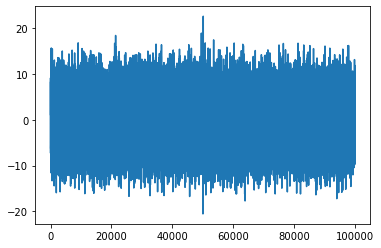

In [38]:
plt.plot(GenerateEnvironment())

Text(0.5, 0, 'Frequency')

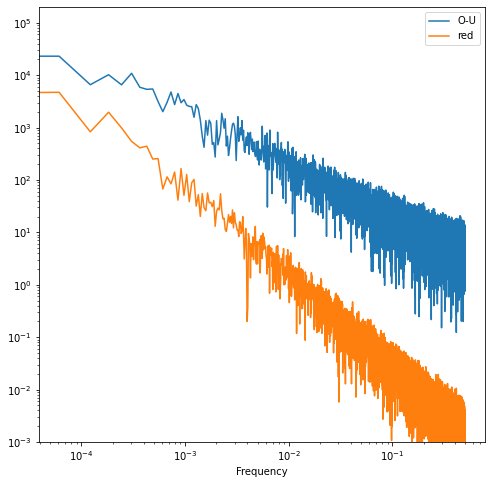

In [164]:
plt.figure(figsize=(8, 8))
#for G in [brownian_noise, pink_noise, white_noise, blue_noise, violet_noise,red_noise]:
#    plot_spectrum(G(2**14))
plot_spectrum(GenerateEnvironment(r=1e-6,n=2**14))
plot_spectrum(red_noise(2**14,1.7))
#plt.legend(['brownian', 'pink', 'white', 'blue', 'violet','red','O-U'])
plt.legend(['O-U','red'])
plt.ylim([1e-3, None]);
plt.xlabel("Frequency")

Text(0.5, 0, 'Exemple trajectory')

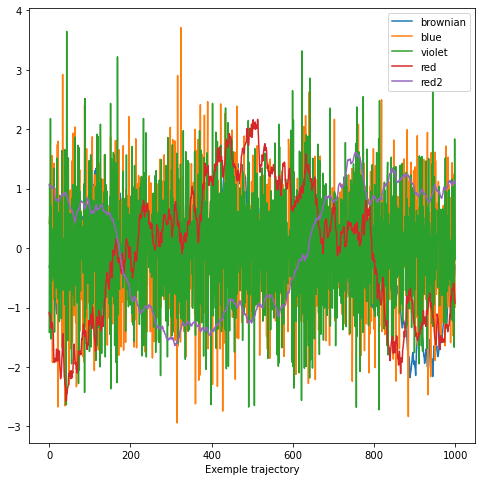

In [62]:
plt.figure(figsize=(8, 8))
for G in [brownian_noise, blue_noise, violet_noise,red_noise]:
    plt.plot(G(1000))
plt.plot(red_noise(1000,1.3))

plt.legend(['brownian', 'blue', 'violet','red','red2'])
plt.xlabel("Exemple trajectory")

### Population trajectories: Maternal bet-hedging, no cue
Here we define a function to simulate a possible population trajectory.

In [50]:
def GenerateTrajectoryMNC(x0=x0,V0=V0,Vr=Vr,w2=w2,rho=rho,sig2_e=sig2_e,nbsteps=nbsteps,tau=tau,Tmax=Tmax,th=[]):
    """This function generates the trajectory of a population for Maternal bet-hedging, No Cue:
    x0 initial means
    V0 initial variance
    Vr reproduction variance
    w2 selection strength
    rho environmental autocorrelation
    sig2_e environmental variance
    nbsteps number of selective events in an organism’s life
    tau the longevity (or time between birth and reproduction)
    Tmax number of generations to be simulated"""
    x          = x0
    z          = x0[0]
    if len(th)==0:
        th         = GenerateEnvironment(r=rho, s2=sig2_e, n = nbsteps*(Tmax+1), time=tau*Tmax)
    thvarprev  = np.var(th[0:nbsteps])
    Vgenetic   = V0
    listx      = [[0]*6]*(Tmax-1) #6 for: l,m,varl,varm,th,thvar
    for t in range(Tmax-1):
        #Environmental parameters
        thmean    = np.mean(th[(t+1)*nbsteps:(t+2)*nbsteps])
        thvar     = np.var(th[(t+1)*nbsteps:(t+2)*nbsteps])
        #Calculation intermediates
        omega_l   = w2+x[1]**2+Vgenetic[1]
        omega_m   = (w2+x[1]**2+Vgenetic[1])/(1 - ((x[0]-thmean)**2+Vgenetic[0])/(w2+x[1]**2+Vgenetic[1]))
        eta_t     = (Vgenetic[1]-Vr[1])/(omega_m+2*(Vgenetic[1]-Vr[1])) #See the text, keep in mind G*(t-1)=2(Gt-Vr)
        #Iteration
        x         = (x[0]+Vgenetic[0]/(Vgenetic[0]+omega_l)*(thmean-x[0]),
                    x[1]-eta_t*x[1])
        Vgenetic  = (1/(1/omega_l  +        1/Vgenetic[0])/2+Vr[0],
                    (eta_t*Vr[1]   +(1-eta_t)*Vgenetic[1])/2+Vr[1])
        thvarprev = thvar
        listx[t]  = list(x)+list(Vgenetic)+[thmean,thvar]
    return np.transpose(listx)

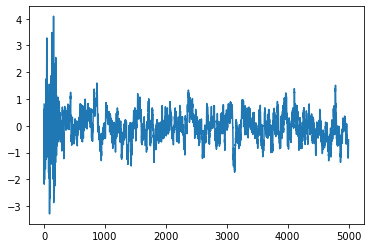

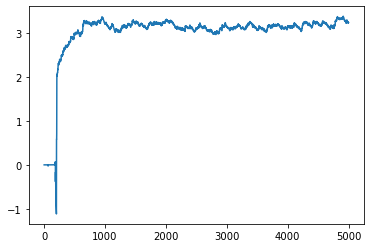

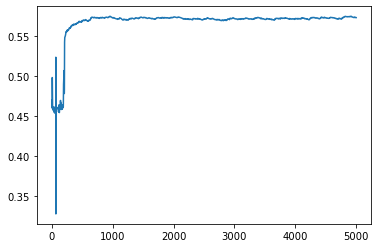

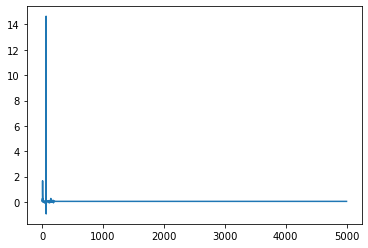

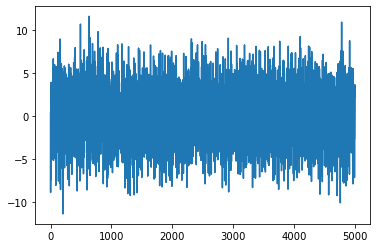

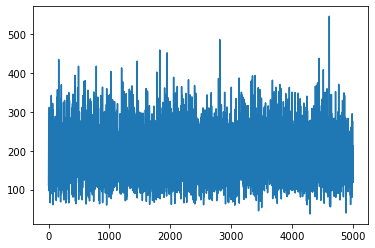

In [127]:
listl,listm,listvl,listvm,listthmean,listthvar = GenerateTrajectoryMNC(x0=(1,1e-10),
                                                                    V0=(0.5,0.05),
                                                                    Vr=[0.3,0.025],
                                                                    w2=1,
                                                                    rho=1,
                                                                    sig2_e=200,
                                                                    nbsteps=20,
                                                                    tau=1000,
                                                                    Tmax=5000)

plt.plot(listl)
plt.figure()
plt.plot(listm)
plt.figure()
plt.plot(listvl)
plt.figure()
plt.plot(listvm)
plt.figure()
plt.plot(listthmean)
plt.figure()
plt.plot(listthvar)

Text(0.5, 0, 'Maternal variability (sd)')

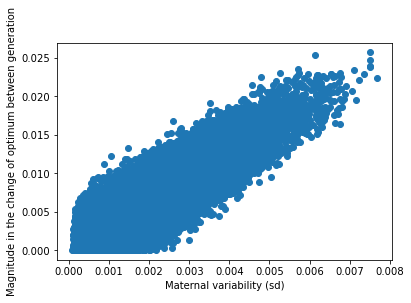

In [166]:
plt.plot(np.sqrt(listthvar[:-1]),np.abs(listthmean[1:]-listthmean[:-1]),"o")
plt.ylabel("Magnitude in the change of optimum between generation")
plt.xlabel("Maternal variability (sd)")

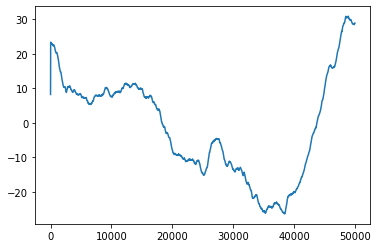

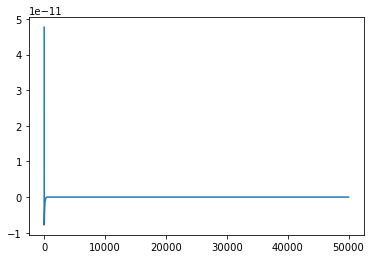

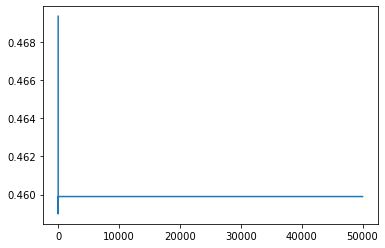

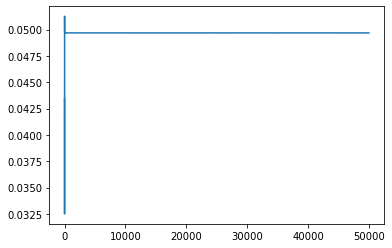

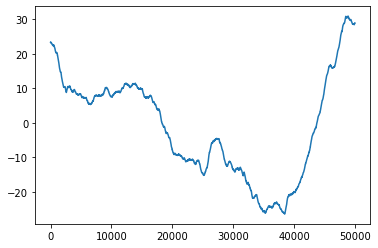

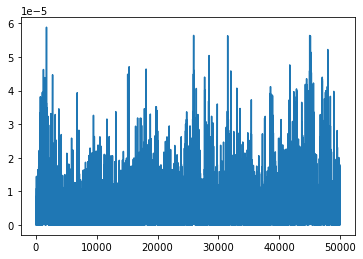

In [165]:
listl,listm,listvl,listvm,listthmean,listthvar = GenerateTrajectoryMNC(x0=(1,1e-10),
                                                                    V0=(0.5,0.05),
                                                                    Vr=[0.3,0.025],
                                                                    w2=1,
                                                                    rho=1,
                                                                    sig2_e=20,
                                                                    nbsteps=20,
                                                                    tau=10000,
                                                                    Tmax=50000,
                                                                    th=20*red_noise(50000*(20+1),1.5))

plt.plot(listl)
plt.figure()
plt.plot(listm)
plt.figure()
plt.plot(listvl)
plt.figure()
plt.plot(listvm)
plt.figure()
plt.plot(listthmean)
plt.figure()
plt.plot(listthvar)

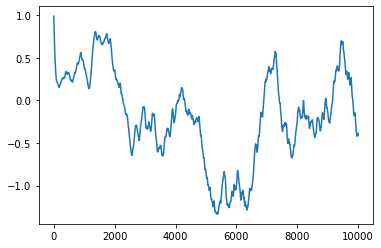

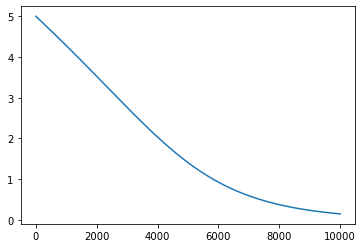

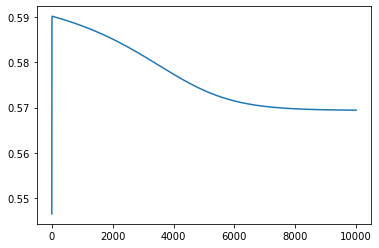

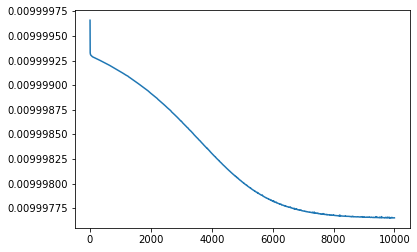

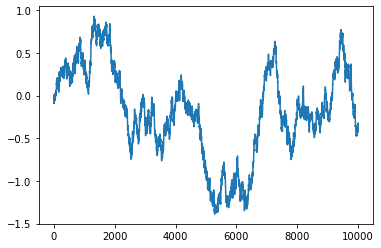

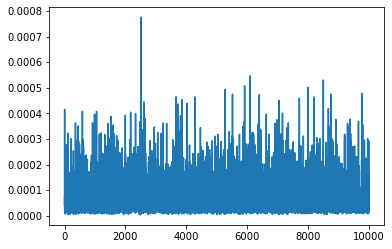

In [129]:
listl,listm,listvl,listvm,listthmean,listthvar = GenerateTrajectoryMNC(x0=(1,5),
                                                                    V0=(0.5,0.01),
                                                                    Vr=[0.3,0.005],
                                                                    w2=10,
                                                                    rho=1e-8,
                                                                    sig2_e=20,
                                                                    nbsteps=20,
                                                                    tau=1000,
                                                                    Tmax=10000)
plt.plot(listl)
plt.figure()
plt.plot(listm)
plt.figure()
plt.plot(listvl)
plt.figure()
plt.plot(listvm)
plt.figure()
plt.plot(listthmean)
plt.figure()
plt.plot(listthvar)

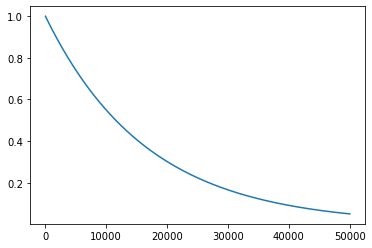

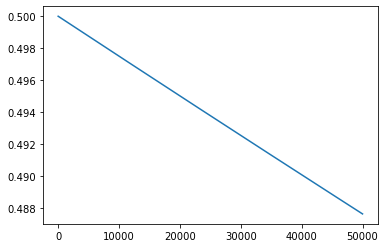

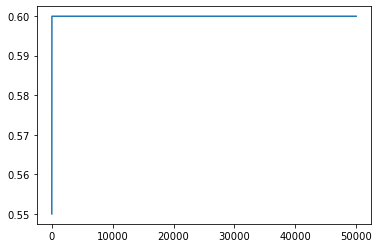

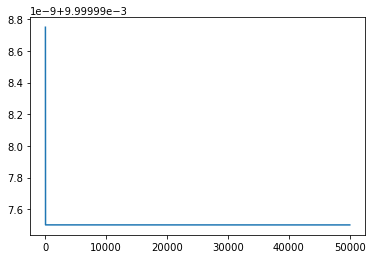

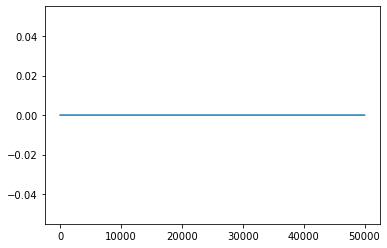

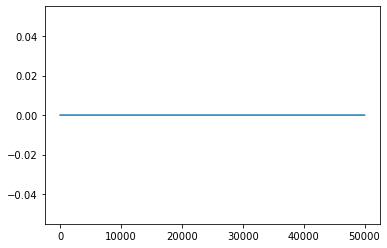

In [10]:
listl,listm,listvl,listvm,listthmean,listthvar = GenerateTrajectoryMNC(x0=(1,0.5),
                                                                    V0=(0.5,0.01),
                                                                    Vr=[0.3,0.005],
                                                                    w2=1e4,
                                                                    rho=1e-6,
                                                                    sig2_e=0,
                                                                    nbsteps=20,
                                                                    tau=1000,
                                                                    Tmax=50000)
plt.plot(listl)
plt.figure()
plt.plot(listm)
plt.figure()
plt.plot(listvl)
plt.figure()
plt.plot(listvm)
plt.figure()
plt.plot(listthmean)
plt.figure()
plt.plot(listthvar)

It can be checked that in the setting above, we get the expected results, as leq=meq=0, Vleq=2Vrl, same Vm

### Conditions for the evolution of m
As we saw in the text, we have two conditions that might cause m to evolve: a first one for a large rho tau, one for a small rho tau.
In the large rho tau case:

In [11]:
nbbins   = 100 #Number of bins for the discretization of the space
nbrep    = 1   #Number of replicates for each bin
x0       = (1,1e-10) #Initial conditions. 
tau      = 10000 #Lifespan
nbsteps  = 20#Number of selective episodes in an organism’s lifetime
w2       = 1 #Inverse selection strength (constant)

V0       = (0.5,0.05) #Genetic variance (again for l, m)
Vr       = [0.3,0.025] #This is the variability during reproduction, in the infinitesimal model

rho      = 1
sig2_e   = np.logspace(np.log(w2*rho)-1,np.log(w2*rho)+4,nbbins) #Variance in the environment


Tmax     = 50000
listm    = np.abs([np.mean([GenerateTrajectoryMNC(x0=x0,V0=V0,Vr=Vr,w2=w2,rho=rho,sig2_e=sig,
                                                nbsteps=nbsteps,tau=tau,Tmax=Tmax)[1][-1] for i in range(nbrep)])
                   for sig in sig2_e])

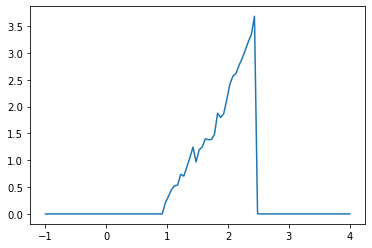

In [12]:
plt.plot(np.log10(sig2_e),listm)

In [15]:
rho      = np.logspace(-8,1,nbbins)
sig2_e   = w2 #Variance in the environment


listm    = np.abs([np.mean([GenerateTrajectoryMNC(x0=x0,V0=V0,Vr=Vr,w2=w2,rho=r,sig2_e=sig2_e,
                                                nbsteps=nbsteps,tau=tau,Tmax=Tmax)[1][-1] for i in range(nbrep)])
                   for r in rho])

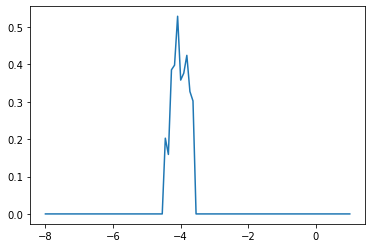

In [16]:
plt.plot(np.log10(rho),listm)

Now the limit case where rho tau is small

In [17]:
x0       = (1,1e-10) #Initial conditions. 
tau      = 10 #Lifespan
nbsteps  = 20#Number of selective episodes in an organism’s lifetime
w2       = 1 #Inverse selection strength (constant)

V0       = (0.5,0.05) #Genetic variance (again for l, m)
Vr       = [0.3,0.025] #This is the variability during reproduction, in the infinitesimal model

rho      = 1e-6
sig2_e   = np.logspace(np.log(2*w2/tau)-1,np.log(2*w2/tau)+4,nbbins) #Variance in the environment


Tmax     = 50000
listm    = np.abs([np.mean([GenerateTrajectoryMNC(x0=x0,V0=V0,Vr=Vr,w2=w2,rho=rho,sig2_e=sig,
                                        nbsteps=nbsteps,tau=tau,Tmax=Tmax)[1][-1] for i in range(nbrep)])
                           for sig in sig2_e])

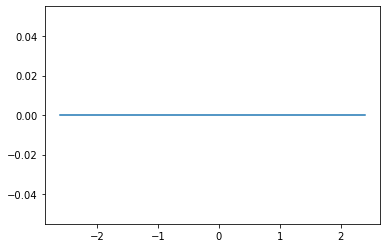

In [18]:
plt.plot(np.log10(sig2_e),listm)

In [19]:
sig2_e   = w2 #Variance in the environment
tau      = np.logspace(-4+np.log(2),1+np.log(2),nbbins)

listm    = np.abs([np.mean([GenerateTrajectoryMNC(x0=x0,V0=V0,Vr=Vr,w2=w2,rho=rho,sig2_e=sig2_e,
                                nbsteps=nbsteps,tau=t,Tmax=Tmax)[1][-1] for i in range(nbrep)])
                   for t in tau])

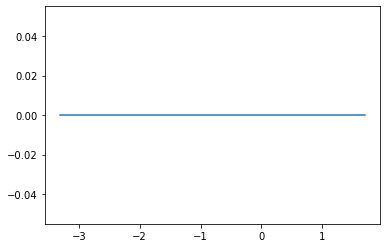

In [20]:
plt.plot(np.log10(tau),listm)

### Population trajectories: Maternal bet-hedging, cue
Here we define a function to simulate a possible population trajectory.

In [38]:
def GenerateTrajectoryMC(x0=x0,V0=V0,Vr=Vr,w2=w2,rho=rho,sig2_e=sig2_e,nbsteps=nbsteps,tau=tau,Tmax=Tmax,th=[]):
    """This function generates the trajectory of a population for Maternal bet-hedging with Cue:
    x0 initial means
    V0 initial variance
    Vr reproduction variance
    w2 selection strength
    rho environmental autocorrelation
    sig2_e environmental variance
    nbsteps number of selective events in an organism’s life
    tau the longevity (or time between birth and reproduction)
    Tmax number of generations to be simulated"""
    x          = x0
    z          = x0[0]
    if len(th)==0:
        th     = GenerateEnvironment(r=rho, s2=sig2_e, n = nbsteps*(Tmax+1), time=tau*Tmax)
    thvarprev  = np.var(th[0:nbsteps])
    Vgenetic   = V0
    listx      = [[0]*6]*(Tmax-1) #6 for: l,m,varl,varm,th,thvar
    for t in range(Tmax-1):
        #Environmental parameters
        thmean    = np.mean(th[(t+1)*nbsteps:(t+2)*nbsteps])
        thvar     = np.var(th[(t+1)*nbsteps:(t+2)*nbsteps])
        #Calculation intermediates
        omega_l   = w2+(x[1]**2+Vgenetic[1])*thvar
        omega_m   = (w2+(x[1]**2+Vgenetic[1])*thvar)/(1 - ((x[0]-thmean)**2+Vgenetic[0])/(w2+(x[1]**2+Vgenetic[1])*thvar))
        eta_t     = (Vgenetic[1]-Vr[1])/(omega_m/thvarprev+2*(Vgenetic[1]-Vr[1])) #See the text, keep in mind G*(t-1)=2(Gt-Vr)
        #Iteration
        x         = (x[0]+Vgenetic[0]/(Vgenetic[0]+omega_l)*(thmean-x[0]),
                    x[1]*(1-eta_t))
        Vgenetic  = (1/(1/omega_l  +        1/Vgenetic[0])/2+Vr[0],
                    (eta_t*Vr[1]   +(1-eta_t)*Vgenetic[1])/2+Vr[1])
        thvarprev = thvar
        listx[t]  = list(x)+list(Vgenetic)+[thmean,thvar]
    return np.transpose(listx)

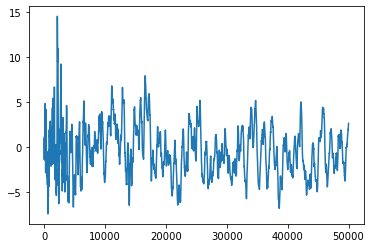

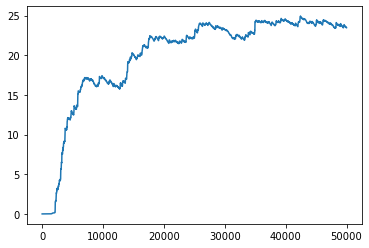

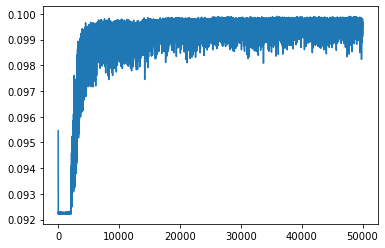

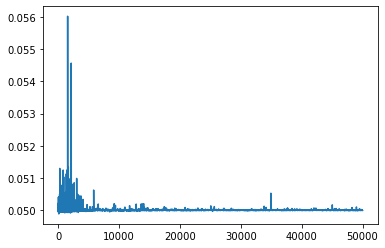

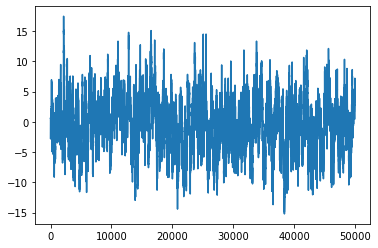

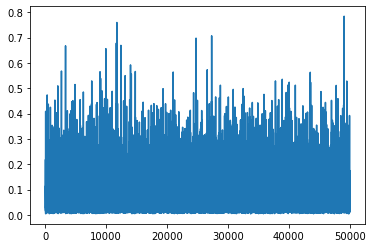

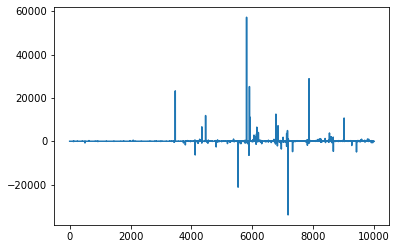

In [58]:
listl,listm,listvl,listvm,listthmean,listthvar = GenerateTrajectoryMC(x0=(1,0.001),
                                                                             V0=(0.1,0.05),
                                                                             Vr=[0.05,0.025],
                                                                             w2=1,
                                                                             rho=1e-5,
                                                                             sig2_e=20,
                                                                             nbsteps=20,
                                                                             tau=1000,
                                                                             Tmax=50000)
plt.plot(listl)
plt.figure()
plt.plot(listm)
plt.figure()
plt.plot(listvl)
plt.figure()
plt.plot(listvm)
plt.figure()
plt.plot(listthmean)
plt.figure()
plt.plot(listthvar)
plt.figure()
plt.plot(listomm)

### Population trajectories: Offspring bet-hedging, no cue
Here we define a function to simulate a possible population trajectory.

In [44]:
def GenerateTrajectoryONC(x0=x0,V0=V0,Vr=Vr,w2=w2,rho=rho,sig2_e=sig2_e,nbsteps=nbsteps,tau=tau,Tmax=Tmax,th=[]):
    """This function generates the trajectory of a population for Offspring bet-hedging, No Cue:
    x0 initial means
    V0 initial variance
    Vr reproduction variance
    w2 selection strength
    rho environmental autocorrelation
    sig2_e environmental variance
    nbsteps number of selective events in an organism’s life
    tau the longevity (or time between birth and reproduction)
    Tmax number of generations to be simulated"""
    x          = x0
    z          = x0[0]
    if len(th)==0:
        th         = GenerateEnvironment(r=rho, s2=sig2_e, n = nbsteps*(Tmax+1), time=tau*Tmax)
    thvarprev  = np.var(th[0:nbsteps])
    Vgenetic   = V0
    listx      = [[0]*6]*(Tmax-1) #6 for: l,m,varl,varm,th,thvar
    for t in range(Tmax-1):
        #Environmental parameters
        thmean    = np.mean(th[(t+1)*nbsteps:(t+2)*nbsteps])
        thvar     = np.var(th[(t+1)*nbsteps:(t+2)*nbsteps])
        #Calculation intermediates
        omega_l   = w2+x[1]**2+Vgenetic[1]
        omega_m   = (w2+x[1]**2+Vgenetic[1])/(1 - ((x[0]-thmean)**2+Vgenetic[0])/(w2+x[1]**2+Vgenetic[1]))
        #Iteration
        x         = (x[0]+Vgenetic[0]/(Vgenetic[0]+omega_l)*(thmean-x[0]),
                    x[1]-Vgenetic[1]/(Vgenetic[1]+omega_m)*x[1])
        Vgenetic  = (1/(1/omega_l  +        1/Vgenetic[0])/2+Vr[0],
                    (1/(1/omega_m  +        1/Vgenetic[1])/2+Vr[1]))
        thvarprev = thvar
        listx[t]  = list(x)+list(Vgenetic)+[thmean,thvar]
    return np.transpose(listx)

In [45]:
def GenerateTrajectoryOC(x0=x0,V0=V0,Vr=Vr,w2=w2,rho=rho,sig2_e=sig2_e,nbsteps=nbsteps,tau=tau,Tmax=Tmax,th=[]):
    """This function generates the trajectory of a population for Offspring bet-hedging, No Cue:
    x0 initial means
    V0 initial variance
    Vr reproduction variance
    w2 selection strength
    rho environmental autocorrelation
    sig2_e environmental variance
    nbsteps number of selective events in an organism’s life
    tau the longevity (or time between birth and reproduction)
    Tmax number of generations to be simulated"""
    x          = x0
    z          = x0[0]
    if len(th)==0:
        th         = GenerateEnvironment(r=rho, s2=sig2_e, n = nbsteps*(Tmax+1), time=tau*Tmax)
    thvarprev  = np.var(th[0:nbsteps])
    Vgenetic   = V0
    listx      = [[0]*6]*(Tmax-1) #6 for: l,m,varl,varm,th,thvar
    for t in range(Tmax-1):
        #Environmental parameters
        thmean    = np.mean(th[(t+1)*nbsteps:(t+2)*nbsteps])
        thvar     = np.var(th[(t+1)*nbsteps:(t+2)*nbsteps])
        #Calculation intermediates
        omega_l   = w2+(x[1]**2+Vgenetic[1])*thvarprev
        omega_m   = (w2+(x[1]**2+Vgenetic[1])*thvarprev)/(1 - ((x[0]-thmean)**2+Vgenetic[0])/(w2+(x[1]**2+Vgenetic[1])*thvarprev))
        #Iteration
        x         = (x[0]+Vgenetic[0]/(Vgenetic[0]+omega_l)*(thmean-x[0]),
                    x[1]-Vgenetic[1]/(Vgenetic[1]+omega_m/thvarprev)*x[1])
        Vgenetic  = (1/(1/omega_l          +        1/Vgenetic[0])/2+Vr[0],
                    (1/(thvarprev/omega_m  +        1/Vgenetic[1])/2+Vr[1]))
        thvarprev = thvar
        listx[t]  = list(x)+list(Vgenetic)+[thmean,thvar]
    return np.transpose(listx)

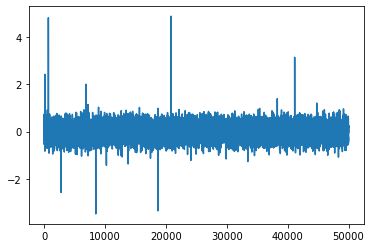

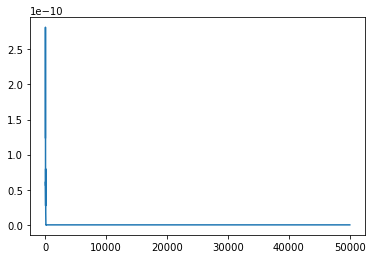

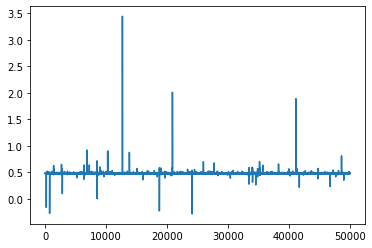

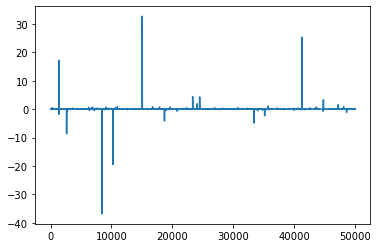

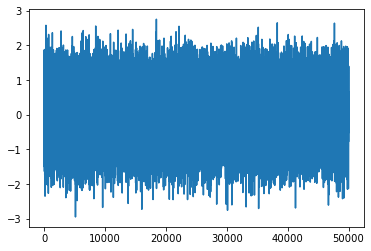

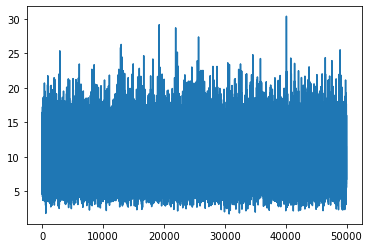

In [114]:
listl,listm,listvl,listvm,listthmean,listthvar = GenerateTrajectoryOC(x0=(1,1e-10),
                                                                    V0=(0.5,0.05),
                                                                    Vr=[0.3,0.025],
                                                                    w2=1,
                                                                    rho=1,
                                                                    sig2_e=10,
                                                                    nbsteps=20,
                                                                    tau=10000,
                                                                    Tmax=50000)

plt.plot(listl)
plt.figure()
plt.plot(listm)
plt.figure()
plt.plot(listvl)
plt.figure()
plt.plot(listvm)
plt.figure()
plt.plot(listthmean)
plt.figure()
plt.plot(listthvar)

In [178]:
nbbins   = 100 #Number of bins for the discretization of the space
nbrep    = 1   #Number of replicates for each bin
x0       = (1,1e-10) #Initial conditions. 
tau      = 10000 #Lifespan
nbsteps  = 20#Number of selective episodes in an organism’s lifetime
w2       = 1 #Inverse selection strength (constant)

V0       = (0.5,0.05) #Genetic variance (again for l, m)
Vr       = [0.3,0.025] #This is the variability during reproduction, in the infinitesimal model

rho      = 1
sig2_e   = np.linspace(w2/10,w2*50,nbbins) #Variance in the environment

Tmax     = 50000
raw      = [GenerateTrajectoryMNC(x0=x0,V0=V0,Vr=Vr,w2=w2,rho=rho,sig2_e=sig,
                                                    nbsteps=nbsteps,tau=tau,Tmax=Tmax)
            for sig in sig2_e]
            for sig in sig2_e]
listmMNC    = [np.mean(np.abs(traj[1][-Tmax//2:]))
               for traj in raw]

listm2MNC   = [np.mean(np.abs(traj[3][-Tmax//2:]))
               for traj in raw]
raw=None
raw2     = [GenerateTrajectoryONC(x0=x0,V0=V0,Vr=Vr,w2=w2,rho=rho,sig2_e=sig,
                                                    nbsteps=nbsteps,tau=tau,Tmax=Tmax)

listmONC    = [np.mean(np.abs(traj[1][-Tmax//2:]))
                       for traj in raw2]
listm2ONC   = [np.mean(np.abs(traj[3][-Tmax//2:]))
                       for traj in raw2]
raw2=None

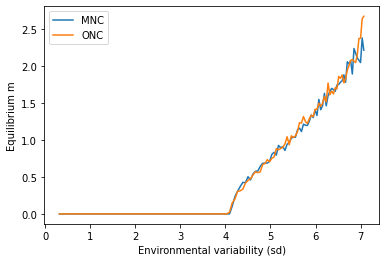

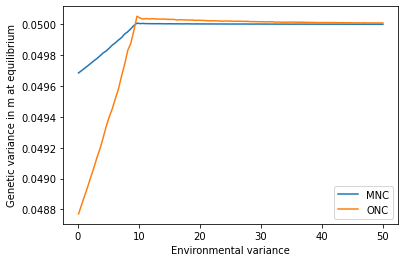

In [181]:
plt.figure()
for l in [listmMNC,listmONC]:
    plt.plot(np.sqrt(sig2_e),l)
plt.xlabel("Environmental variability (sd)")
plt.ylabel("Equilibrium m")
plt.legend(["MNC","ONC"])

plt.figure()
for l in [listm2MNC,listm2ONC]:
    plt.plot(sig2_e,l)
plt.xlabel("Environmental variance")
plt.ylabel("Genetic variance in m at equilibrium")
plt.legend(["MNC","ONC"])

Text(0.5, 1.0, 'Initial convergence to equilibrium')

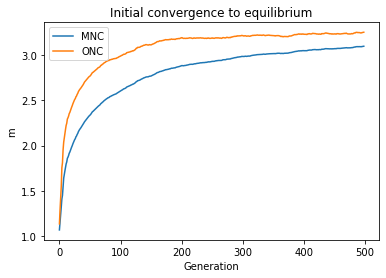

In [97]:
nbrep = 100
th=[GenerateEnvironment(r=1,s2=200,n=20*500,time=10000*500) for k in range(nbrep)]
listmMNC = np.mean(np.abs([GenerateTrajectoryMNC(x0=(1,1),
                                                 V0=(0.5,0.05),
                                                 Vr=[0.3,0.025],
                                                 w2=1,
                                                 rho=1,
                                                 sig2_e=25,
                                                 nbsteps=20,
                                                 tau=10000,
                                                 Tmax=500,th=th[k])[1]
                            for k in range(nbrep)]),axis=0)

listmONC = np.mean(np.abs([GenerateTrajectoryONC(x0=(1,1),
                                                 V0=(0.5,0.05),
                                                 Vr=[0.3,0.025],
                                                 w2=1,
                                                 rho=1,
                                                 sig2_e=25,
                                                 nbsteps=20,
                                                 tau=10000,
                                                 Tmax=500)[1]
                            for k in range(nbrep)]),axis=0)

plt.figure()
plt.plot(np.abs(listmMNC))
plt.plot(np.abs(listmONC))
plt.legend(["MNC","ONC"])
plt.xlabel("Generation")
plt.ylabel("m")
plt.title("Initial convergence to equilibrium")

In [51]:
nbbins   = 100 #Number of bins for the discretization of the space
nbrep    = 1   #Number of replicates for each bin
x0       = (1,1e-10) #Initial conditions. 
tau      = 10 #Lifespan
nbsteps  = 20#Number of selective episodes in an organism’s lifetime
w2       = 1 #Inverse selection strength (constant)

V0       = (0.5,0.05) #Genetic variance (again for l, m)
Vr       = [0.3,0.025] #This is the variability during reproduction, in the infinitesimal model

rho      = 1e-3
sig2_e   = np.linspace(w2/10,w2*50,nbbins) #Variance in the environment

Tmax     = 50000
raw      = [GenerateTrajectoryMNC(x0=x0,V0=V0,Vr=Vr,w2=w2,rho=rho,sig2_e=sig,
                                                    nbsteps=nbsteps,tau=tau,Tmax=Tmax)
            for sig in sig2_e]
listmMNC    = [np.mean(np.abs(traj[1][-Tmax//2:]))
               for traj in raw]

listm2MNC   = [np.mean(np.abs(traj[3][-Tmax//2:]))
               for traj in raw]
raw=None
raw2     = [GenerateTrajectoryONC(x0=x0,V0=V0,Vr=Vr,w2=w2,rho=rho,sig2_e=sig,
                                                    nbsteps=nbsteps,tau=tau,Tmax=Tmax)
            for sig in sig2_e]

listmONC    = [np.mean(np.abs(traj[1][-Tmax//2:]))
                       for traj in raw2]
listm2ONC   = [np.mean(np.abs(traj[3][-Tmax//2:]))
                       for traj in raw2]
raw2=None

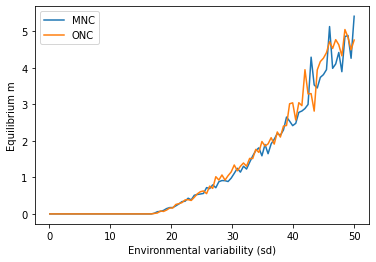

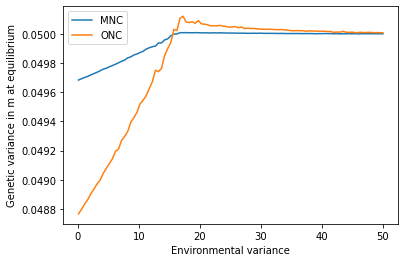

In [52]:
plt.figure()
for l in [listmMNC,listmONC]:
    plt.plot(sig2_e,np.array(l)**2)
plt.xlabel("Environmental variability (sd)")
plt.ylabel("Equilibrium m")
plt.legend(["MNC","ONC"])

plt.figure()
for l in [listm2MNC,listm2ONC]:
    plt.plot(sig2_e,l)
plt.xlabel("Environmental variance")
plt.ylabel("Genetic variance in m at equilibrium")
plt.legend(["MNC","ONC"])

Text(0.5, 1.0, 'Initial convergence to equilibrium')

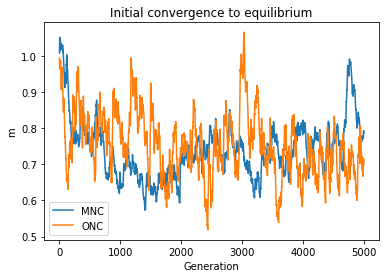

In [118]:
nbrep = 10
#th=[GenerateEnvironment(r=1e-3,s2=200,n=20*5000,time=10*5000) for k in range(nbrep)]
listmMNC = np.mean(np.abs([GenerateTrajectoryMNC(x0=(1,1),
                                                 V0=(0.5,0.05),
                                                 Vr=[0.3,0.025],
                                                 w2=1,
                                                 rho=1e-3,
                                                 sig2_e=25,
                                                 nbsteps=20,
                                                 tau=10,
                                                 Tmax=5000)[1]
                            for k in range(nbrep)]),axis=0)

listmONC = np.mean(np.abs([GenerateTrajectoryONC(x0=(1,1),
                                                 V0=(0.5,0.05),
                                                 Vr=[0.3,0.025],
                                                 w2=1,
                                                 rho=1e-3,
                                                 sig2_e=25,
                                                 nbsteps=20,
                                                 tau=10,
                                                 Tmax=5000)[1]
                            for k in range(nbrep)]),axis=0)

plt.figure()
plt.plot(np.abs(listmMNC))
plt.plot(np.abs(listmONC))
plt.legend(["MNC","ONC"])
plt.xlabel("Generation")
plt.ylabel("m")
plt.title("Initial convergence to equilibrium")

#### If there is a cue, things get weird and out of hand

In [85]:
nbbins   = 100 #Number of bins for the discretization of the space
nbrep    = 1   #Number of replicates for each bin
x0       = (1,0.001) #Initial conditions. 
tau      = 100 #Lifespan
nbsteps  = 20#Number of selective episodes in an organism’s lifetime
w2       = 1 #Inverse selection strength (constant)

V0       = (0.1,0.1) #Genetic variance (again for l, m)
Vr       = [0.05,0.05] #This is the variability during reproduction, in the infinitesimal model

rho      = 1e-4
sig2_e   = np.linspace(w2/10,w2*20,nbbins) #Variance in the environment

Tmax     = 50000
raw      = [GenerateTrajectoryMC(x0=x0,V0=V0,Vr=Vr,w2=w2,rho=rho,sig2_e=sig,
                                 nbsteps=nbsteps,tau=tau,Tmax=Tmax)
            for sig in sig2_e]
listmMC    = [np.mean(np.abs(traj[1][-Tmax//2:]))
               for traj in raw]

listm2MC   = [np.mean(np.abs(traj[3][-Tmax//2:]))
               for traj in raw]
raw=None
raw2     = [GenerateTrajectoryOC(x0=x0,V0=V0,Vr=Vr,w2=w2,rho=rho,sig2_e=sig,
                                 nbsteps=nbsteps,tau=tau,Tmax=Tmax)
            for sig in sig2_e]

listmOC    = [np.mean(np.abs(traj[1][-Tmax//2:]))
                       for traj in raw2]
listm2OC   = [np.mean(np.abs(traj[3][-Tmax//2:]))
                       for traj in raw2]
raw2=None

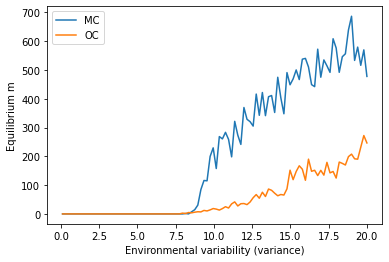

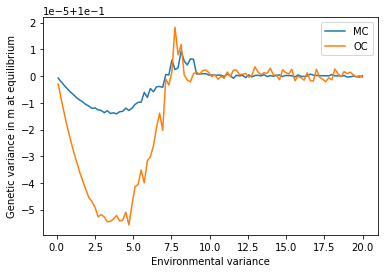

In [86]:

plt.figure()
for l in [listmMC,listmOC]:

    plt.plot(sig2_e,np.array(l)**2)
plt.xlabel("Environmental variability (variance)")
plt.ylabel("Equilibrium m")
plt.legend(["MC","OC"])

plt.figure()
for l in [listm2MC,listm2OC]:
    plt.plot(sig2_e,l)
plt.xlabel("Environmental variance")
plt.ylabel("Genetic variance in m at equilibrium")
plt.legend(["MC","OC"])